# Estimating Proportions

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [293]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [294]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [295]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapter we solved the 101 Bowls Problem, and I admitted that it is not really about guessing which bowl the cookies came from; it is about estimating proportions.

In this chapter, we take another step toward Bayesian statistics by solving the Euro problem.
We'll start with the same prior distribution, and we'll see that the update is the same, mathematically.
But I will argue that it is a different problem, philosophically, and use it to introduce two defining elements of Bayesian statistics: choosing prior distributions, and using probability to represent the unknown.

## The Euro Problem

In *Information Theory, Inference, and Learning Algorithms*, David MacKay poses this problem:

"A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  \`It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  \`If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

"But [MacKay asks] do these data give evidence that the coin is biased rather than fair?"

To answer that question, we'll proceed in two steps.
First we'll use the binomial distribution to see where that 7% came from; then we'll use Bayes's Theorem to estimate the probability that this coin comes up heads.


## The Binomial Distribution

Suppose I tell you that a coin is "fair", that is, the probability of heads is 50%.  If you spin it twice, there are four outcomes: `HH`, `HT`, `TH`, and `TT`.  All four outcomes have the same probability, 25%.

If we add up the total number of heads, there are three possible results: 0, 1, or 2.  The probabilities of 0 and 2 are 25%, and the probability of 1 is 50%.

More generally, suppose the probability of heads is $p$ and we spin the coin $n$ times.  The probability that we get a total of $k$ heads is given by the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):

$$\binom{n}{k} p^k (1-p)^{n-k}$$

for any value of $k$ from 0 to $n$, including both.
The term $\binom{n}{k}$ is the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), usually pronounced "n choose k".

We could evaluate this expression ourselves, but we can also use the SciPy function `binom.pmf`.
For example, if we flip a coin `n=2` times and the probability of heads is `p=0.5`, here's the probability of getting `k=1` heads:

In [296]:
from scipy.stats import binom
import numpy as np
n = 2
p = 0.5
k = 1
binom.pmf(k, n, p)

ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [297]:
from scipy.stats import binom

n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

Instead of providing a single value for `k`, we can also call `binom.pmf` with an array of values.

In [298]:
import numpy as np
ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [299]:
from empiricaldist import Pmf
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


The result is a NumPy array with the probability of 0, 1, or 2 heads.
If we put these probabilities in a `Pmf`, the result is the distribution of `k` for the given values of `n` and `p`.

Here's what it looks like:

In [300]:
from empiricaldist import Pmf

pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [301]:
def make_binominal(n, p):
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

pmf_k = make_binominal(n=100, p=0.5)
pmf_k

,probs
0,7.888609e-31
1,7.888609e-29
2,3.904861e-27
3,1.275588e-25
4,3.093301e-24
...,...
96,3.093301e-24
97,1.275588e-25
98,3.904861e-27
99,7.888609e-29


The following function computes the binomial distribution for given values of `n` and `p` and returns a `Pmf` that represents the result.

In [302]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

Here's what it looks like with `n=250` and `p=0.5`:

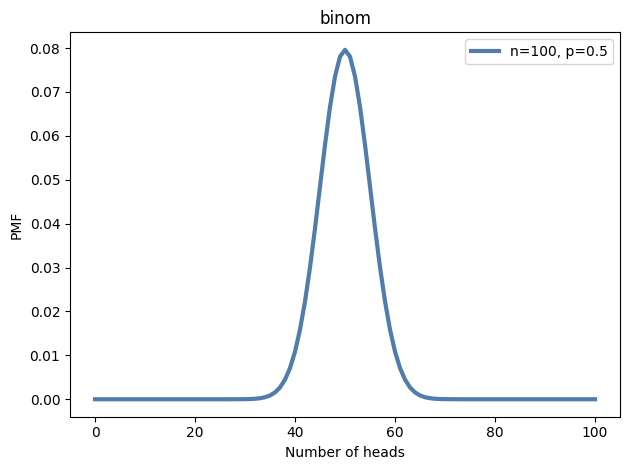

In [303]:
from utils import decorate

pmf_k = make_binomial(n=100, p=0.5)

pmf_k.plot(label='n=100, p=0.5')

decorate(xlabel='Number of heads', ylabel='PMF', title='binom')

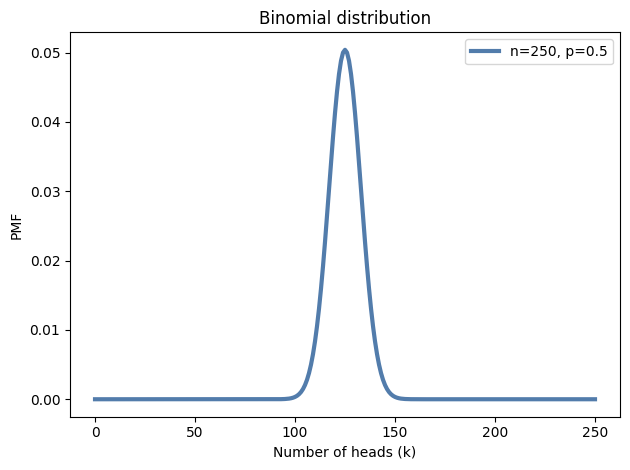

In [304]:
from utils import decorate

pmf_k = make_binomial(n=250, p=0.5)
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

The most likely quantity in this distribution is 125:

In [305]:
pmf_k.max_prob()

125

But even though it is the most likely quantity, the probability that we get exactly 125 heads is only about 5%.

In [306]:
pmf_k[125]

0.050412213147309655

In MacKay's example, we got 140 heads, which is even less likely than 125:

In [307]:
pmf_k[140]

0.008357181724918204

In [308]:
# prob greater equal
def prob_ge(pmf, threshold):
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total    

pmf_k.prob_ge(140)

0.03321057562002163

In the article MacKay quotes, the statistician says, "If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%."

We can use the binomial distribution to check his math.  The following function takes a PMF and computes the total probability of quantities greater than or equal to `threshold`. 

In [309]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

Here's the probability of getting 140 heads or more:

In [310]:
prob_ge(pmf_k, 140)

0.03321057562002163

`Pmf` provides a method that does the same computation.

In [311]:
pmf_k.prob_ge(140)

0.03321057562002163

The result is about 3.3%, which is less than the quoted 7%.  The reason for the difference is that the statistician includes all outcomes "as extreme as" 140, which includes outcomes less than or equal to 110.

To see where that comes from, recall that the expected number of heads is 125.  If we get 140, we've exceeded that expectation by 15.
And if we get 110, we have come up short by 15.

7% is the sum of both of these "tails", as shown in the following figure.

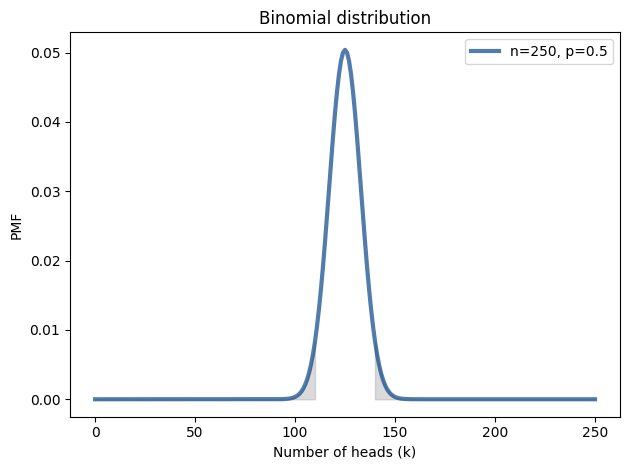

In [312]:
import matplotlib.pyplot as plt

def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

qs = pmf_k.index
fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

Here's how we compute the total probability of the left tail.

In [313]:
pmf_k.prob_le(110)

0.03321057562002164

In [314]:
# sum of prob of both tails = less than 7 %
pmf_k.prob_le(110) + pmf_k.prob_ge(140)

0.06642115124004327

The probability of outcomes less than or equal to 110 is also 3.3%,
so the total probability of outcomes "as extreme" as 140 is 6.6%.

The point of this calculation is that these extreme outcomes are unlikely if the coin is fair.

That's interesting, but it doesn't answer MacKay's question.  Let's see if we can.

## Bayesian Estimation

Any given coin has some probability of landing heads up when spun
on edge; I'll call this probability `x`.
It seems reasonable to believe that `x` depends
on physical characteristics of the coin, like the distribution
of weight.
If a coin is perfectly balanced, we expect `x` to be close to 50%, but
for a lopsided coin, `x` might be substantially different.
We can use Bayes's theorem and the observed data to estimate `x`.

For simplicity, I'll start with a uniform prior, which assumes that all values of `x` are equally likely.
That might not be a reasonable assumption, so we'll come back and consider other priors later.

We can make a uniform prior like this:

In [315]:
hypos = np.linspace(0, 1, 101)

# hypos stands for names of hypotheses, 1 stands for prob, in summation it is uniform
prior = Pmf(1/len(hypos), hypos) # uniform prior

# equivalent, (for updating) to the following 
# prior = Pmf(1, hypos) # uniform prior
prior

,probs
0.00,0.009901
0.01,0.009901
0.02,0.009901
0.03,0.009901
0.04,0.009901
...,...
0.96,0.009901
0.97,0.009901
0.98,0.009901
0.99,0.009901


`hypos` is an array of equally spaced values between 0 and 1.

We can use the hypotheses to compute the likelihoods, like this:

In [316]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

likelihood_heads

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

I'll put the likelihoods for heads and tails in a dictionary to make it easier to do the update.

In [317]:
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

To represent the data, I'll construct a string with `H` repeated 140 times and `T` repeated 110 times.

In [318]:
dataset = 'H' * 140 + 'T' * 110
dataset

'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT'

The following function does the update.

In [319]:
def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize() # normalization is outside the loop, it is necessary to normalize only once at the end. (more efficient!)
    return pmf

The first argument is a `Pmf` that represents the prior.
The second argument is a sequence of strings.
Each time through the loop, we multiply `pmf` by the likelihood of one outcome, `H` for heads or `T` for tails.

Notice that `normalize` is outside the loop, so the posterior distribution only gets normalized once, at the end.
That's more efficient than normalizing it after each spin (although we'll see later that it can also cause problems with floating-point arithmetic).

Here's how we use `update_euro`.

In [320]:
posterior = prior.copy()
update_euro(posterior, dataset)

,probs
0.00,0.000000e+00
0.01,1.256330e-207
0.02,5.731921e-166
0.03,8.338711e-142
0.04,8.269265e-125
...,...
0.96,2.107677e-83
0.97,1.624102e-96
0.98,2.911941e-115
0.99,9.293081e-148


And here's what the posterior looks like.

In [321]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

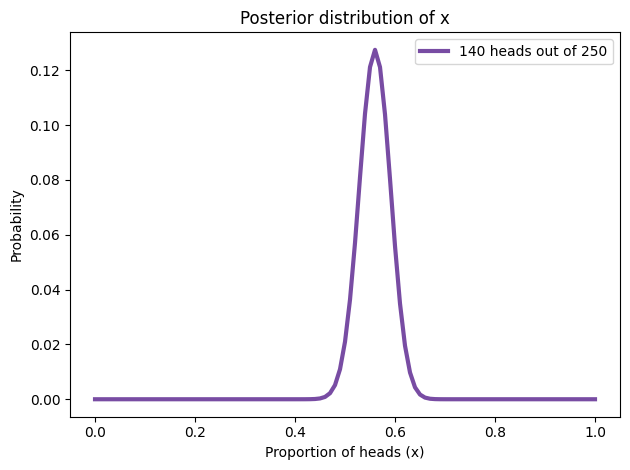

In [322]:
posterior.plot(label='140 heads out of 250', color='C4')
decorate_euro(title='Posterior distribution of x')

In [323]:
# MAP estimate = 140/250
posterior.max_prob()



0.56

This figure shows the posterior distribution of `x`, which is the proportion of heads for the coin we observed.

The posterior distribution represents our beliefs about `x` after seeing the data.
It indicates that values less than 0.4 and greater than 0.7 are unlikely; values between 0.5 and 0.6 are the most likely.

In fact, the most likely value for `x` is 0.56 which is the proportion of heads in the dataset, `140/250`.

In [324]:
posterior.max_prob()

0.56

## Triangle Prior

So far we've been using a uniform prior:

In [325]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

But that might not be a reasonable choice based on what we know about coins.
I can believe that if a coin is lopsided, `x` might deviate substantially from 0.5, but it seems unlikely that the Belgian Euro coin is so imbalanced that `x` is 0.1 or 0.9.

It might be more reasonable to choose a prior that gives
higher probability to values of `x` near 0.5 and lower probability
to extreme values.

As an example, let's try a triangle-shaped prior.
Here's the code that constructs it:

In [326]:
def decorate_prior(title):
    decorate(xlabel='Hypothesis = "Prob. of heads"',
             ylabel='P(H|D) = "Probability given data"',
             title=title)

In [327]:
# Hypotheses are the respective probabilities of heads.
hypos = np.linspace(0, 1, 101)
hypos

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

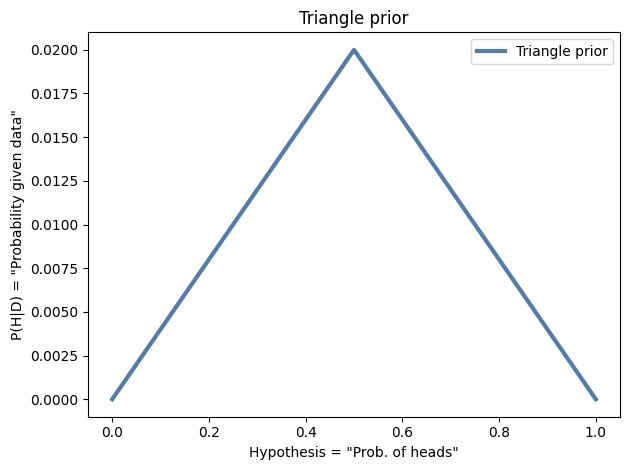

In [328]:
# Prior is a "triangle"
# Building a triangle, it goes up from 0 to 50, then down from 50 to 0
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)
a

triangle = Pmf(a, hypos)
triangle.normalize()
triangle.plot(label = "Triangle prior")
decorate_prior(title="Triangle prior")

In [329]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()
triangle

,probs
0.00,0.0000
0.01,0.0004
0.02,0.0008
0.03,0.0012
0.04,0.0016
...,...
0.96,0.0016
0.97,0.0012
0.98,0.0008
0.99,0.0004


`arange` returns a NumPy array, so we can use `np.append` to append `ramp_down` to the end of `ramp_up`.
Then we use `a` and `hypos` to make a `Pmf`.

The following figure shows the result, along with the uniform prior.

In [330]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

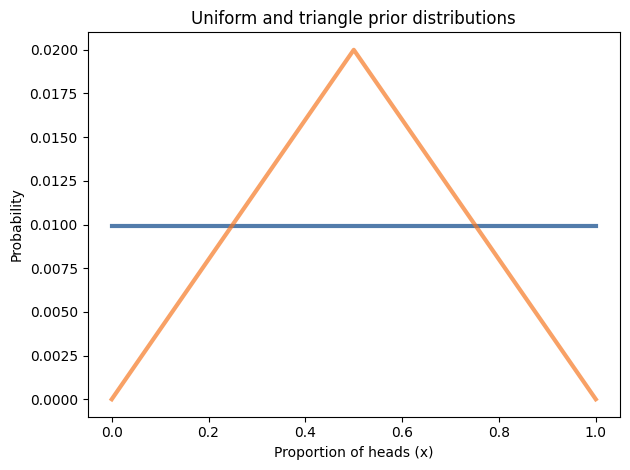

In [331]:
uniform.plot()
triangle.plot()
decorate_euro(title='Uniform and triangle prior distributions')

Now we can update both priors with the same data:


In [332]:
uniform
triangle
# dataset

,probs
0.00,0.0000
0.01,0.0004
0.02,0.0008
0.03,0.0012
0.04,0.0016
...,...
0.96,0.0016
0.97,0.0012
0.98,0.0008
0.99,0.0004


In [333]:
posterior1 = update_euro(uniform, dataset)
update_euro(triangle, dataset)

,probs
0.00,0.000000e+00
0.01,2.856563e-209
0.02,2.606575e-167
0.03,5.688007e-143
0.04,7.520849e-126
...,...
0.96,1.916921e-84
0.97,1.107834e-97
0.98,1.324197e-116
0.99,2.113001e-149


Here are the posteriors.

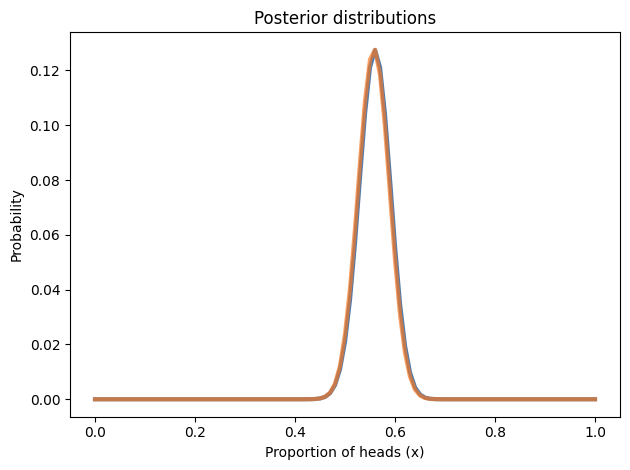

In [334]:
uniform.plot()
triangle.plot()
decorate_euro(title='Posterior distributions')

The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice.

And that's good news.
To see why, imagine two people who disagree angrily about which prior is better, uniform or triangle.
Each of them has reasons for their preference, but neither of them can persuade the other to change their mind.

But suppose they agree to use the data to update their beliefs.
When they compare their posterior distributions, they find that there is almost nothing left to argue about.

This is an example of **swamping the priors**: with enough
data, people who start with different priors will tend to
converge on the same posterior distribution.


## The Binomial Likelihood Function

So far we've been computing the updates one spin at a time, so for the Euro problem we have to do 250 updates.

A more efficient alternative is to compute the likelihood of the entire dataset at once.
For each hypothetical value of `x`, we have to compute the probability of getting 140 heads out of 250 spins.

Well, we know how to do that; this is the question the binomial distribution answers.
If the probability of heads is $p$, the probability of $k$ heads in $n$ spins is:

$$\binom{n}{k} p^k (1-p)^{n-k}$$

And we can use SciPy to compute it.
The following function takes a `Pmf` that represents a prior distribution and a tuple of integers that represent the data:

In [335]:
# We dont want to update every time, we simply calc. likelihood of entire dataset, for each hypothesis we compute probability of data
from scipy.stats import binom
import pandas as pd

data = 140, 250 # 140 heads out of 250 spins total 
k, n = data
hypos = uniform.qs
likelihood_per_hypo = binom.pmf(k, n, hypos)

table = pd.DataFrame(dict(likelihood=likelihood_per_hypo, data=str(data), hypo=hypos))
table

# hypos

,likelihood,data,hypo
0,0.000000e+00,"(140, 250)",0.00
1,5.005301e-208,"(140, 250)",0.01
2,2.283634e-166,"(140, 250)",0.02
3,3.322196e-142,"(140, 250)",0.03
4,3.294528e-125,"(140, 250)",0.04
...,...,...,...
96,8.397121e-84,"(140, 250)",0.96
97,6.470526e-97,"(140, 250)",0.97
98,1.160136e-115,"(140, 250)",0.98
99,3.702423e-148,"(140, 250)",0.99


In [336]:
from scipy.stats import binom

'''
Function expects a prior as Pmf object and data in the form of a tuple (k, n) where k is the number of successes and n the number of trials.
'''
def update_binomial(pmf, data):
    k, n = data # k success out of n trials
    hypos = pmf.qs # hypotheses are quantities of pmf
    likelihood_per_hypo = binom.pmf(k, n, hypos) # likelihood of data for each hypo
    pmf *= likelihood_per_hypo # posterior = prior times likelihood, that is the update
    pmf.normalize() # normalize the posterior
    return pmf

The data are represented with a tuple of values for `k` and `n`, rather than a long string of outcomes.
Here's the update.

In [337]:
uniform2 = Pmf(1/len(hypos), hypos, name='uniform2')
data = 140, 250
posterior2 = update_binomial(uniform2.copy(), data)

# uniform2[140/250]

posterior2[140/250]

0.12745318058391034

And here's what the posterior looks like.

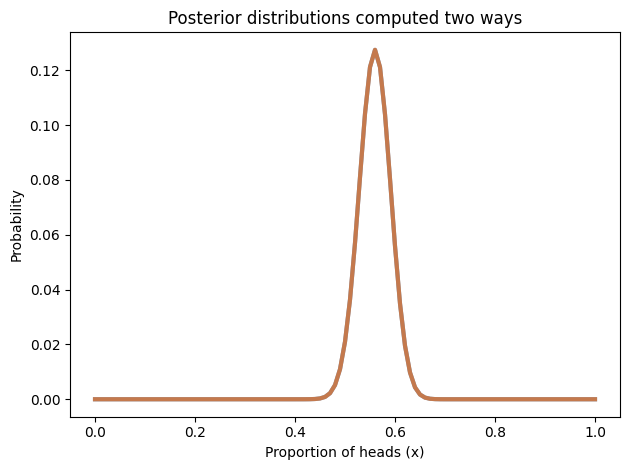

In [338]:
uniform.plot()
posterior2.plot()
decorate_euro(title='Posterior distributions computed two ways')

We can use `allclose` to confirm that the result is the same as in the previous section except for a small floating-point round-off.

In [339]:
np.allclose(uniform, posterior2)

True

But this way of doing the computation is much more efficient.

## Bayesian Statistics

You might have noticed similarities between the Euro problem and the 101 Bowls Problem in <<_101Bowls>>.
The prior distributions are the same, the likelihoods are the same, and with the same data the results would be the same.
But there are two differences.

The first is the choice of the prior.
With 101 bowls, the uniform prior is implied by the statement of the problem, which says that we choose one of the bowls at random with equal probability.

In the Euro problem, the choice of the prior is subjective; that is, reasonable people could disagree, maybe because they have different information about coins or because they interpret the same information differently.

Because the priors are subjective, the posteriors are subjective, too.
And some people find that problematic.

The other difference is the nature of what we are estimating.
In the 101 Bowls problem, we choose the bowl randomly, so it is uncontroversial to compute the probability of choosing each bowl.
In the Euro problem, the proportion of heads is a physical property of a given coin.
Under some interpretations of probability, that's a problem because physical properties are not considered random.

As an example, consider the age of the universe.
Currently, our best estimate is 13.80 billion years, but it might be off by 0.02 billion years in either direction (see [here](https://en.wikipedia.org/wiki/Age_of_the_universe)).

Now suppose we would like to know the probability that the age of the universe is actually greater than 13.81 billion years.
Under some interpretations of probability, we would not be able to answer that question.
We would be required to say something like, "The age of the universe is not a random quantity, so it has no probability of exceeding a particular value."

Under the Bayesian interpretation of probability, it is meaningful and useful to treat physical quantities as if they were random and compute probabilities about them.

In the Euro problem, the prior distribution represents what we believe about coins in general and the posterior distribution represents what we believe about a particular coin after seeing the data.
So we can use the posterior distribution to compute probabilities about the coin and its proportion of heads.

The subjectivity of the prior and the interpretation of the posterior are key differences between using Bayes's Theorem and doing Bayesian statistics.

Bayes's Theorem is a mathematical law of probability; no reasonable person objects to it.
But Bayesian statistics is surprisingly controversial.
Historically, many people have been bothered by its subjectivity and its use of probability for things that are not random.

If you are interested in this history, I recommend Sharon Bertsch McGrayne's book, *[The Theory That Would Not Die](https://yalebooks.yale.edu/book/9780300188226/theory-would-not-die)*.

## Summary

In this chapter I posed David MacKay's Euro problem and we started to solve it.
Given the data, we computed the posterior distribution for `x`, the probability a Euro coin comes up heads.

We tried two different priors, updated them with the same data, and found that the posteriors were nearly the same.
This is good news, because it suggests that if two people start with different beliefs and see the same data, their beliefs tend to converge.

This chapter introduces the binomial distribution, which we used to compute the posterior distribution more efficiently.
And I discussed the differences between applying Bayes's Theorem, as in the 101 Bowls problem, and doing Bayesian statistics, as in the Euro problem.

However, we still haven't answered MacKay's question: "Do these data give evidence that the coin is biased rather than fair?"
I'm going to leave this question hanging a little longer; we'll come back to it in <<_Testing>>.

In the next chapter, we'll solve problems related to counting, including trains, tanks, and rabbits.

But first you might want to work on these exercises.

## Exercises


**Exercise:** In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.

Suppose a player appearing in their first game gets 3 hits out of 3 attempts.  What is the posterior distribution for their probability of getting a hit?

For this exercise, I'll construct the prior distribution by starting with a uniform distribution and updating it with imaginary data until it has a shape that reflects my background knowledge of batting averages.

Here's the uniform prior:

In [428]:
# Hypothesis space goes from 0.1 to 0.4 and has uniform prior

hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)
prior.normalize()
prior

,probs
0.100,0.009901
0.103,0.009901
0.106,0.009901
0.109,0.009901
0.112,0.009901
...,...
0.388,0.009901
0.391,0.009901
0.394,0.009901
0.397,0.009901


In [429]:
hypos

array([0.1  , 0.103, 0.106, 0.109, 0.112, 0.115, 0.118, 0.121, 0.124,
       0.127, 0.13 , 0.133, 0.136, 0.139, 0.142, 0.145, 0.148, 0.151,
       0.154, 0.157, 0.16 , 0.163, 0.166, 0.169, 0.172, 0.175, 0.178,
       0.181, 0.184, 0.187, 0.19 , 0.193, 0.196, 0.199, 0.202, 0.205,
       0.208, 0.211, 0.214, 0.217, 0.22 , 0.223, 0.226, 0.229, 0.232,
       0.235, 0.238, 0.241, 0.244, 0.247, 0.25 , 0.253, 0.256, 0.259,
       0.262, 0.265, 0.268, 0.271, 0.274, 0.277, 0.28 , 0.283, 0.286,
       0.289, 0.292, 0.295, 0.298, 0.301, 0.304, 0.307, 0.31 , 0.313,
       0.316, 0.319, 0.322, 0.325, 0.328, 0.331, 0.334, 0.337, 0.34 ,
       0.343, 0.346, 0.349, 0.352, 0.355, 0.358, 0.361, 0.364, 0.367,
       0.37 , 0.373, 0.376, 0.379, 0.382, 0.385, 0.388, 0.391, 0.394,
       0.397, 0.4  ])

And here is a dictionary of likelihoods, with `Y` for getting a hit and `N` for not getting a hit.

In [430]:
# P(D|H)

likelihood_per_hypo = {
    'Y': hypos, # Hit - Getting a hit
    'N': 1-hypos # Miss - Not getting a hit
}

likelihood_per_hypo

{'Y': array([0.1  , 0.103, 0.106, 0.109, 0.112, 0.115, 0.118, 0.121, 0.124,
        0.127, 0.13 , 0.133, 0.136, 0.139, 0.142, 0.145, 0.148, 0.151,
        0.154, 0.157, 0.16 , 0.163, 0.166, 0.169, 0.172, 0.175, 0.178,
        0.181, 0.184, 0.187, 0.19 , 0.193, 0.196, 0.199, 0.202, 0.205,
        0.208, 0.211, 0.214, 0.217, 0.22 , 0.223, 0.226, 0.229, 0.232,
        0.235, 0.238, 0.241, 0.244, 0.247, 0.25 , 0.253, 0.256, 0.259,
        0.262, 0.265, 0.268, 0.271, 0.274, 0.277, 0.28 , 0.283, 0.286,
        0.289, 0.292, 0.295, 0.298, 0.301, 0.304, 0.307, 0.31 , 0.313,
        0.316, 0.319, 0.322, 0.325, 0.328, 0.331, 0.334, 0.337, 0.34 ,
        0.343, 0.346, 0.349, 0.352, 0.355, 0.358, 0.361, 0.364, 0.367,
        0.37 , 0.373, 0.376, 0.379, 0.382, 0.385, 0.388, 0.391, 0.394,
        0.397, 0.4  ]),
 'N': array([0.9  , 0.897, 0.894, 0.891, 0.888, 0.885, 0.882, 0.879, 0.876,
        0.873, 0.87 , 0.867, 0.864, 0.861, 0.858, 0.855, 0.852, 0.849,
        0.846, 0.843, 0.84 , 0.837, 0.834, 

Here's a dataset that yields a reasonable prior distribution.

In [408]:
# 25 times HIT, 75 times miss
dataset = 'Y' * 25 + 'N' * 75
dataset

'YYYYYYYYYYYYYYYYYYYYYYYYYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'

And here's the update with the imaginary data.

In [409]:
for data in dataset:
    prior *= likelihood_per_hypo[data]

prior.normalize()

1.346234079898069e-25

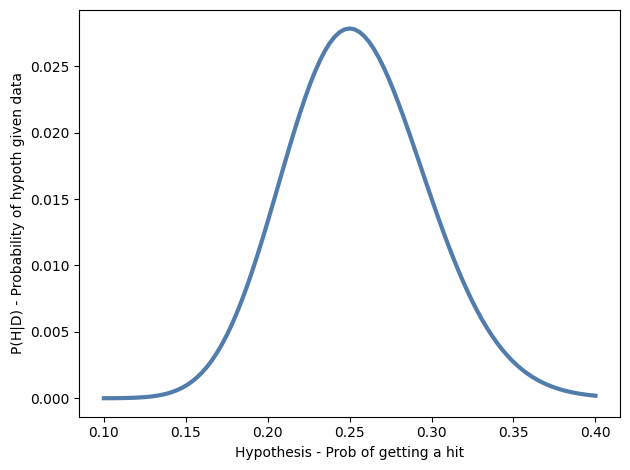

In [410]:
prior.plot()
decorate(
    xlabel='Hypothesis - Prob of getting a hit',
    ylabel='P(H|D) - Probability of hypoth given data'
)


Finally, here's what the prior looks like.

In [411]:
prior.max_prob()

0.25

This distribution indicates that most players have a batting average near 250, with only a few players below 175 or above 350.  I'm not sure how accurately this prior reflects the distribution of batting averages in Major League Baseball, but it is good enough for this exercise.

Now update this distribution with the data and plot the posterior.  What is the most likely quantity in the posterior distribution?

<Axes: >

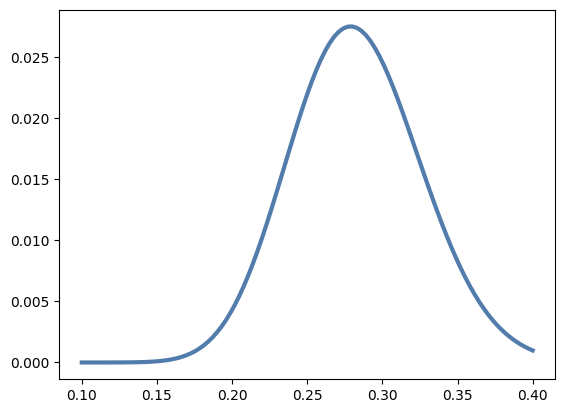

In [412]:
# Solution using for loop goes here
posterior1 = prior.copy()

for data in 'YYYY':
    posterior1 *= likelihood_per_hypo[data]

posterior1.normalize()
posterior1.plot()

In [413]:
posterior1.max_prob()

0.28

In [415]:
# solution using data in the form of tuple (k,n)

data_kn = 4, 4

def update_binomial_baseball(pmf, data):
    k, n = data # k success out of n trials
    hypos = pmf.qs # hypotheses are quantities of pmf
    likelihood_per_hypo = binom.pmf(k, n, hypos) # likelihood of data for each hypo
    pmf *= likelihood_per_hypo # posterior = prior times likelihood, that is the update
    pmf.normalize() # normalize the posterior
    return pmf

posterior_kn = update_binomial_baseball(prior.copy(), data_kn)
posterior_kn.max_prob()

0.28

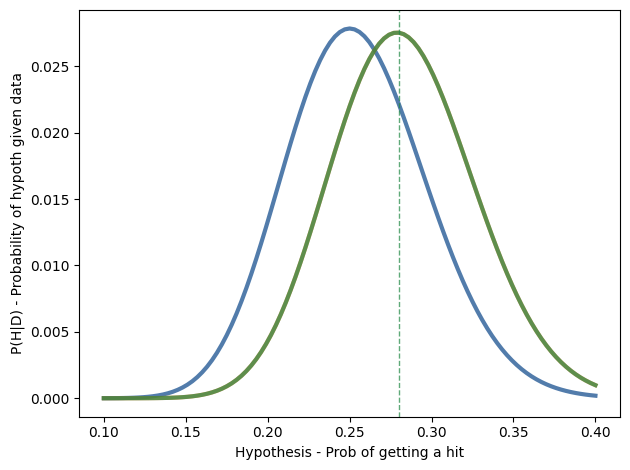

In [417]:
# from matplotlib.pyplot import plot as plt
import matplotlib.pyplot as plt

prior.plot()
posterior1.plot() # the posteriors calculated in different way overlap
posterior_kn.plot()
decorate(
    xlabel='Hypothesis - Prob of getting a hit',
    ylabel='P(H|D) - Probability of hypoth given data'
)

plt.axvline(posterior_kn.max_prob(), 
            color='C2', 
            label='MAP estimate', 
            linestyle='--',
            linewidth=1
            )

**Exercise:** Whenever you survey people about sensitive issues, you have to deal with [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias), which is the tendency of people to adjust their answers to show themselves in the most positive light.
One way to improve the accuracy of the results is [randomized response](https://en.wikipedia.org/wiki/Randomized_response).

As an example, suppose you want to know how many people cheat on their taxes.
If you ask them directly, it is likely that some of the cheaters will lie.
You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,

* If they get heads, they report YES.

* If they get tails, they honestly answer the question "Do you cheat on your taxes?"

If someone says YES, we don't know whether they actually cheat on their taxes; they might have flipped heads.
Knowing this, people might be more willing to answer honestly.

Suppose you survey 100 people this way and get 80 YESes and 20 NOs.  Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes?  What is the most likely quantity in the posterior distribution?

In [436]:
# Solution goes here
'''
1st solution is just for a single individual answering first yes and then no with prior 1/2 1/2
'''
# D = Y
# H -> Cheat, Not Cheat


hypos = ['cheat', 'not cheat']
prior_tax = Pmf(1/2, hypos)
prior_tax

likelihood = {
    'Y' : np.array([1, 1/2]),
    'N' : np.array([0, 1/2])
}


dataset = 'Y' * 1 + 'N' * 1

posterior_tax = prior_tax.copy()
for data in dataset:
    posterior_tax *= likelihood[data]

posterior_tax.normalize()
posterior_tax

,probs
cheat,0.0
not cheat,1.0


In [440]:
dataset = 'Y' * 80 + 'N' * 20
dataset

'YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYNNNNNNNNNNNNNNNNNNNN'

In [442]:
'''
Solution using binom.pmf
'''

hypos = np.linspace(0.0, 1.0, 101)
prior = Pmf(1, hypos)
prior.normalize()
prior




,probs
0.00,0.009901
0.01,0.009901
0.02,0.009901
0.03,0.009901
0.04,0.009901
...,...
0.96,0.009901
0.97,0.009901
0.98,0.009901
0.99,0.009901


In [443]:
data_kn_tax = 80, 100

def update_binomial_taxes(pmf, data):
    k, n = data # k success out of n trials
    hypos = pmf.qs # hypotheses are quantities of pmf
    likelihood_per_hypo = binom.pmf(k, n, 1/2 + 1/2*hypos) # likelihood of data for each hypo
    pmf *= likelihood_per_hypo # posterior = prior times likelihood, that is the update
    pmf.normalize() # normalize the posterior
    return pmf

posterior_kn = update_binomial_taxes(prior.copy(), data_kn_tax)
posterior_kn.max_prob()

0.6

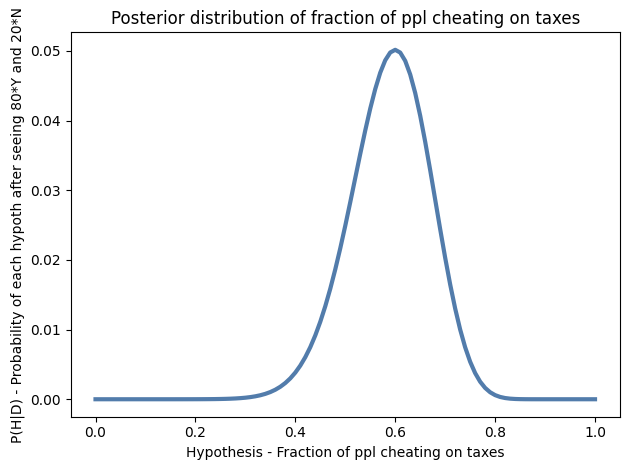

In [445]:
posterior_kn.plot()
decorate(
    xlabel='Hypothesis - Fraction of ppl cheating on taxes',
    ylabel='P(H|D) - Probability of each hypoth after seeing 80*Y and 20*N',
    title='Posterior distribution of fraction of ppl cheating on taxes'
)

In [452]:
# Solution using iteration and likelihoods as a dictionary
prior 

likelihood = {
    'Y' : 1/2 + 1/2*hypos,
    'N' : 1/2*(1-hypos)
}

posterior2 = prior.copy()
for data in dataset:
    posterior2 *= likelihood[data]

posterior2.normalize()
posterior2.max_prob()

0.6

**Exercise:** Suppose you want to test whether a coin is fair, but you don't want to spin it hundreds of times.
So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate.  Specifically, suppose the probability is `y=0.2` that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of `x`?
What happens as you vary the value of `y`?

In [460]:
# Solution goes here
y = 0.2
D = 140, 250
hypos = np.linspace(0.0, 1.0, 101)
prior = Pmf(1, hypos)
prior.normalize()

def update_binomial_shifting_coin(pmf, data, y):
    k, n = data # k success out of n trials
    xs = pmf.qs # hypotheses are quantities of pmf, representing probability of coinflip resulting in heads

    # prob of heads * not shift + prob of tails * shift
    likelihood_per_hypo = binom.pmf(k, n, xs*(1-y) + (1-xs)*y) # likelihood of data for each hypo


    pmf *= likelihood_per_hypo # posterior = prior times likelihood, that is the update
    pmf.normalize() # normalize the posterior
    return pmf

In [457]:
# Solution goes here
posterior_shifting_coin = update_binomial_shifting_coin(prior.copy(), D, y)
posterior_shifting_coin.max_prob()

0.6

<Axes: >

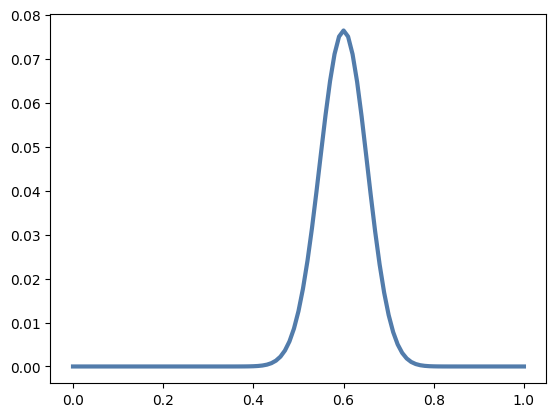

In [459]:
posterior_shifting_coin.plot()

In [462]:
# Solution goes here
posterior00 = update_binomial_shifting_coin(prior.copy(), D, 0.0)
posterior02 = update_binomial_shifting_coin(prior.copy(), D, 0.2)
posterior04 = update_binomial_shifting_coin(prior.copy(), D, 0.4)

<Axes: >

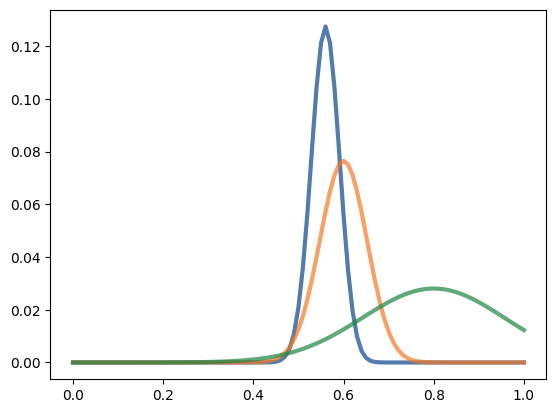

In [463]:
# Solution goes here
posterior00.plot(label='y=0.0')
posterior02.plot(label='y=0.2')
posterior04.plot(label='y=0.4')

In [464]:
posterior00.max_prob(), posterior02.max_prob(), posterior04.max_prob()

(0.56, 0.6, 0.8)

**Exercise:** In preparation for an alien invasion, the Earth Defense League (EDL) has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, `x`.

Based on previous tests, the distribution of `x` in the population of designs is approximately uniform between 0.1 and 0.4.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, an EDL general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad? 
That is, does it increase or decrease your estimate of `x` for the Alien Blaster 9000?

Hint: If the probability of hitting each target is $x$, the probability of hitting one target in both tests
is $\left[2x(1-x)\right]^2$.

In [470]:
# Solution goes here
xs = np.linspace(0.1, 0.4, 101)
prior_alien = Pmf(1, xs)
prior_alien.normalize()

# D = "Same # of targets hit in each test"
# P(D|H) = 0 targets, 1 target, 2 targets
likelihood = (1-xs)**4 + (2*xs*(1-xs))**2 + xs**4

posterior_alien = prior_alien * likelihood
posterior_alien.normalize()

posterior_alien.max_prob()

0.1

<Axes: >

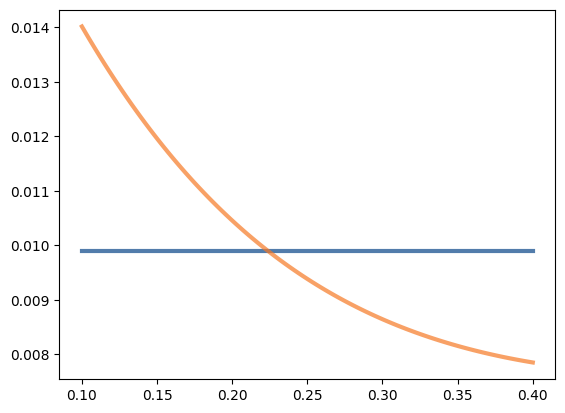

In [471]:
# Solution goes here
prior_alien.plot()
posterior_alien.plot()

# Solution

# Getting the same result in both tests is more likely for 
# extreme values of `x` and least likely when `x=0.5`.

# In this example, the prior indicates that `x` is less than 0.5,
# and the update gives more weight to extreme values.

# So the dataset makes lower values of `x` more likely.

In [360]:
# Solution goes here

In [361]:
# Solution goes here

In [362]:
# Solution goes here

In [363]:
# Solution goes here

In [364]:
# Solution goes here